In [167]:
import sys
from loguru import logger
from bs4 import BeautifulSoup
import pandas as pd
import regex as re
import networkx as nx
import matplotlib.pyplot as plt

logger.remove()
logger.add(sys.stderr, 
           level="DEBUG",
           format="{time:HH:mm:ss} | {level} | {message}")


5

### Create Network Graph `G`

In [153]:
def create_graph(rel_df, types_df):

    G = nx.Graph() 

    # Add nodes with entity_type property
    entities = set(rel_df['entity_1']).union(set(rel_df['entity_2']))
    
    for entity in entities:
        entity_type = types_df.loc[types_df['entity_name'] == entity, 'entity_type'].values
        assert len(entity_type) > 0, f"Entity type not found for entity: {entity}"
        G.add_node(entity, entity_type = entity_type[0])
            
    # Add edges
    for _, row in rel_df.iterrows():
        relationship_type = row['relationship']
        assert len(entity_type) > 0, f"Relationship type not found for entities: {row}"
        G.add_edge(row['entity_1'], row['entity_2'], relationship = relationship_type)
    
    return G

### Visualize Graph

In [154]:
def visualize_graph(G):                                                                    
    
    plt.figure(figsize = (12, 8))
    pos = nx.kamada_kawai_layout(G)

    # Draw nodes with specific shapes
    nx.draw_networkx_nodes(G, 
                        pos, 
                        node_size = 50, 
                        node_color='skyblue')

    nx.draw_networkx_edges(G, 
                        pos)

    nx.draw_networkx_labels(G, 
                            pos, 
                            font_size = 5, 
                            font_color = 'black')


    ## Draw Graph
    plt.title('Network Graph')
    plt.show()

### Combine Network Graphs

In [171]:
def join_graphs(G, H):
    
    ### First, screen for only items from right_graph and have a relationship to an item in left_graph
    added_edges = 0
    joined_graph = G.copy()

    
    for u, v in H.edges():
        
        if G.has_node(u) or G.has_node(v):
            joined_graph.add_edge(u, v, **H[u][v])
            added_edges += 1
            logger.debug(f"Relationship added | Entity 1: {u} | Entity 2: {v} | Properties: {H[u][v]}")

            

    ## Debug information
    G_nodes = G.number_of_nodes()
    joined_nodes = joined_graph.number_of_nodes()
    added_nodes = joined_nodes - G_nodes
    
    logger.debug(f"G Nodes: {G.number_of_nodes()}")
    logger.debug(f"H Nodes: {H.number_of_nodes()}")
    logger.debug(f"Nodes joined: {added_nodes}")
    logger.debug(f"Edges joined: {added_edges}")
    logger.info(f"Nodes after join: {joined_graph.number_of_nodes()}")

    return joined_graph

### Isolate Subgraphs

[networkx Connected Components Documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html)

In [172]:
def parse_subgraphs(G):
    
    # sorted = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

    return S[0]




### Rough Fit

### Main

In [175]:
def main(csv_left, csv_right, csv_types):
    
    df_left = pd.read_csv(csv_left)
    df_right = pd.read_csv(csv_right)
    df_types = pd.read_csv(csv_types)
    
    G = create_graph(df_left, df_types)
    H = create_graph(df_right, df_types)
    
    GH = join_graphs(G, H)
    
    # parse_subgraphs(GH)
    
    return GH

In [176]:
csv_left = "Extracted Data/relationships_irgc.csv"
csv_right = "Extracted Data/relationships_mideast.csv"
csv_types = "Extracted Data/entity_types.csv"

joined = main(csv_left, csv_right, csv_types)

print(joined)

19:53:30 | DEBUG | Relationship added | Entity 1: Hizballah | Entity 2: Mhd Amer Alchwiki | Properties: {'relationship': 'Providing support to'}
19:53:30 | DEBUG | Relationship added | Entity 1: Hizballah | Entity 2: Hasan Nasrallah | Properties: {'relationship': 'Acting for or on behalf of'}
19:53:30 | DEBUG | Relationship added | Entity 1: Hizballah | Entity 2: Ibrahim Aqil | Properties: {'relationship': 'playing a significant role in'}
19:53:30 | DEBUG | Relationship added | Entity 1: Hizballah | Entity 2: Fu'Ad Shukr | Properties: {'relationship': 'playing a significant role in'}
19:53:30 | DEBUG | Relationship added | Entity 1: Hizballah | Entity 2: Mustafa Badr Al Din | Properties: {'relationship': 'playing a significant role in'}
19:53:30 | DEBUG | Relationship added | Entity 1: Tadbir Kish Medical And Pharmaceutical Company | Entity 2: Global Vision Group | Properties: {'relationship': 'Providing support to'}
19:53:30 | DEBUG | Relationship added | Entity 1: Islamic Revolutiona

Graph with 175 nodes and 173 edges


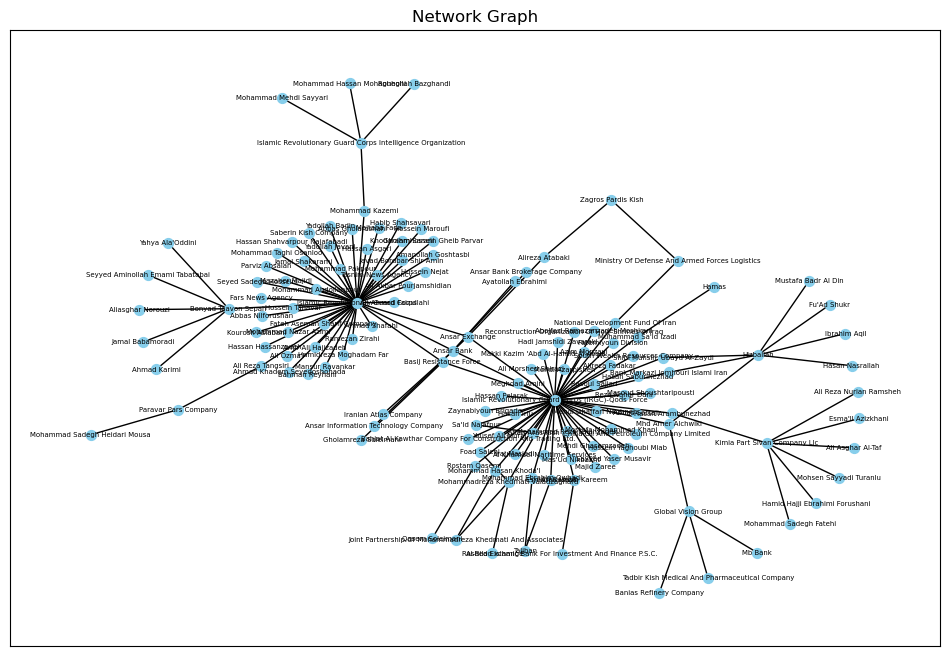

In [177]:
largest = parse_subgraphs(joined)
visualize_graph(largest)

## Graph Gallery

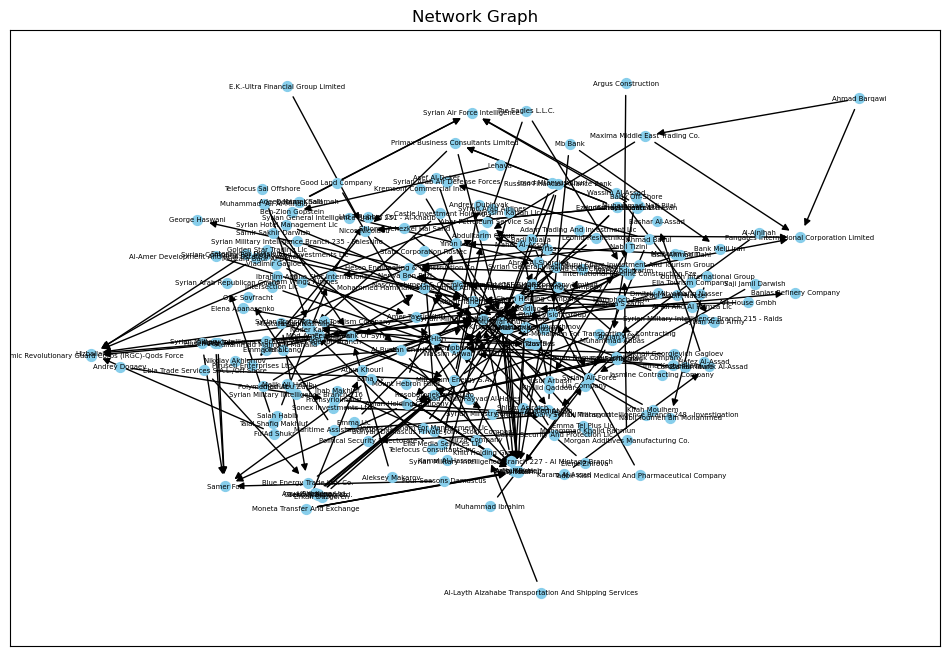

In [58]:
df = pd.read_csv("Extracted Data/relationships_mideast.csv")
mideast_graph = create_graph(df, types_df)
visualize_network_graph(mideast_graph)

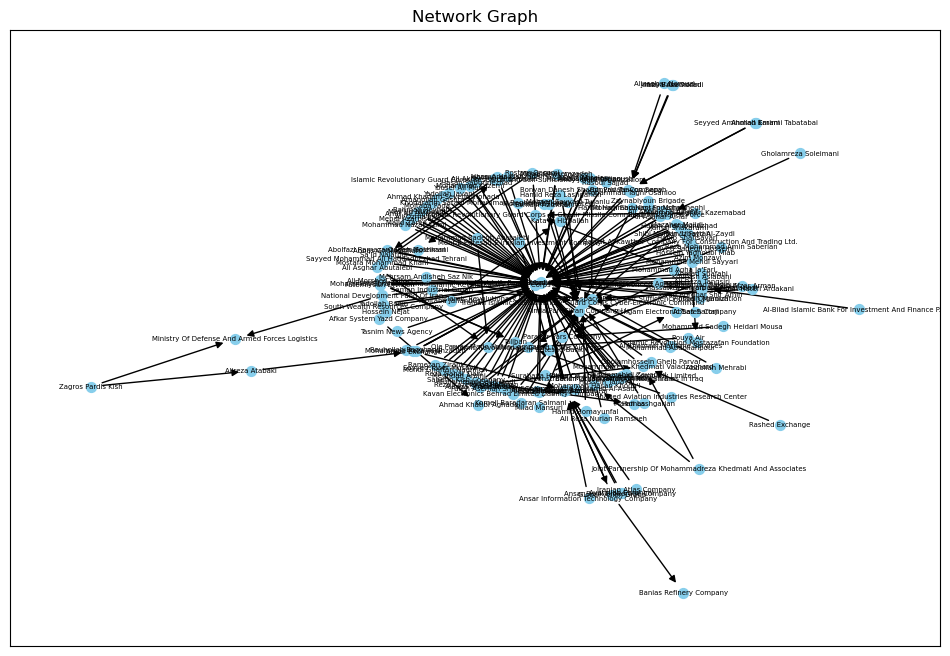

In [59]:
df = pd.read_csv("Extracted Data/relationships_irgc.csv")
irgc_graph = create_graph(df, types_df)
visualize_network_graph(irgc_graph)

## Merge Graphs

![](https://external-preview.redd.it/hiu5Y-qTIBfzkKh2R97zjaMBhCluDBFTRp7Rs7n5uI8.jpg?auto=webp&s=af34175fb9e56c78106e48296d8a9d5ed0a14ebb)

In [60]:


combined_graph = combine_graphs(irgc_graph, mideast_graph)

2024-10-16 21:48:27.474 | DEBUG    | __main__:combine_graphs:15 - Edge added
2024-10-16 21:48:27.476 | DEBUG    | __main__:combine_graphs:15 - Edge added
2024-10-16 21:48:27.477 | DEBUG    | __main__:combine_graphs:15 - Edge added
2024-10-16 21:48:27.477 | DEBUG    | __main__:combine_graphs:15 - Edge added
2024-10-16 21:48:27.478 | DEBUG    | __main__:combine_graphs:15 - Edge added
2024-10-16 21:48:27.479 | DEBUG    | __main__:combine_graphs:15 - Edge added


169


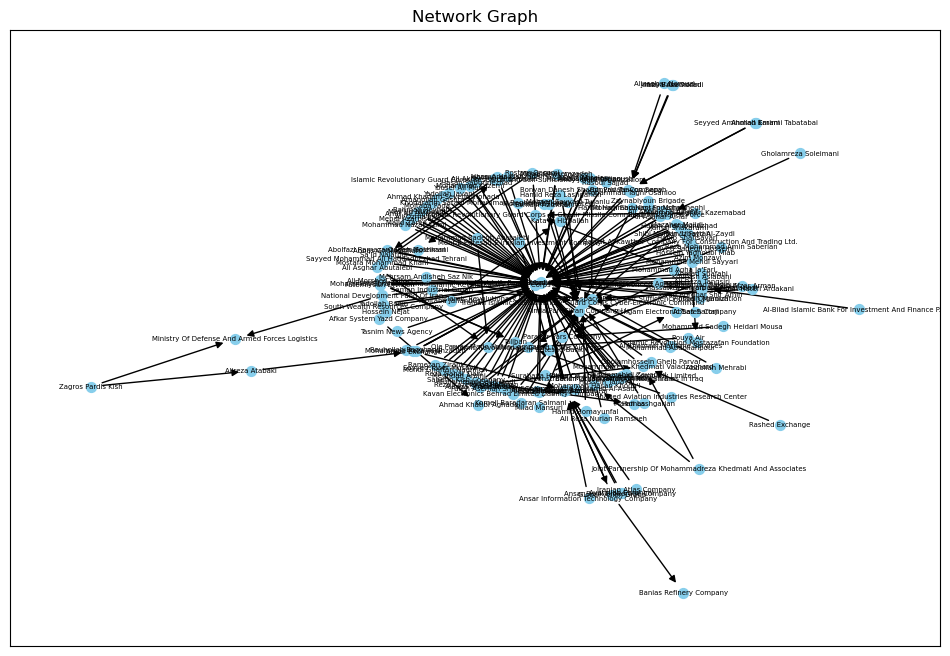

In [53]:
print(len(combined_graph))
visualize_network_graph(combined_graph)

In [62]:
combined_graph.nodes()

NodeView(('Javad Bordbar Shir Amin', 'Pishgam Electronic Safeh Company', 'Hassan Shahvarpour Najafabadi', 'Mohammad Pakpour', 'Al-Bilad Islamic Bank For Investment And Finance P.S.C.', 'Kourosh Asiabani', 'Ahmad Shafahi', 'Reza Mohammad Amin Saberian', 'Hasan Arambunezhad', 'Azim Monzavi', 'Hossein Yaghoubi Miab', 'Mohammad Mehdi Sayyari', 'Bahjat Al Kawthar Company For Construction And Trading Ltd.', 'Seyed Sadegh Hosseini', "Shibl Muhsin 'Ubayd Al-Zaydi", 'Saeed Aghajani', 'Habib Shahsavari', 'Ali Reza Tangsiri', 'Parviz Fattah', 'Jamal Shakarami', 'Mazaher Majidi', 'Bonyad Taavon Sepah', 'Ali Asghar Al-Taf', 'Zaynabiyoun Brigade', 'Ali Ahmad Faizullahi', 'Jahan Aras Kish', 'Mohammad Hassan Mohagheghi', 'Mahmud Bagheri Kazemabad', 'Mohammadreza Khedmati Valadzaghard', 'Hamid Hajji Ebrahimi Forushani', 'Banias Refinery Company', 'Mohammad Taghi Osanloo', 'Rasoul Sajjad', 'National Development Fund Of Iran', "Kata'Ib Hizballah", 'Masoud Shoushtaripousti', 'Gholamreza Soleimani', 'Alias

## Save Graph as CSV

In [27]:
import pandas as pd
import networkx as nx

# Assume the graph G is already created

# Extract node data
nodes_data = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
nodes_data.index.name = 'entity'

# Extract edge data with additional attributes
edges_data = []

for u, v, data in G.edges(data=True):
    edge = {'entity_1': u, 'entity_2': v}
    edge.update(data)
    edges_data.append(edge)
    
edges_data = pd.DataFrame(edges_data)

# Save nodes and edges to CSV files
nodes_data.to_csv('nodes_data.csv')
edges_data.to_csv('edges_data.csv')

print("Node and edge data saved to 'nodes_data.csv' and 'edges_data.csv'")

# Combine them into one CSV file:
combined_data = edges_data.merge(nodes_data, left_on='entity_1', right_index=True, how='left', suffixes=('', '_entity_1'))
combined_data = combined_data.merge(nodes_data, left_on='entity_2', right_index=True, how='left', suffixes=('', '_entity_2'))
combined_data.to_csv('network_data.csv', index=False)

print("Network data saved to 'network_data.csv'")



Node and edge data saved to 'nodes_data.csv' and 'edges_data.csv'
Network data saved to 'network_data.csv'
